<a href="https://colab.research.google.com/github/IIaJIpaTiN/Diplom/blob/main/Code/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключение библиотек

In [ ]:
import os
import numpy as np
import torch
from matplotlib import pyplot as plt
import librosa
from librosa import display

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

***Получение спектрограммы аудиофайла***

Принимает на вход путь к файлу, частоту дескритезации и кол-во фреймов на 
которые необхлжимо разделить спектрограмму.

Возвращает спектрограмму в виде двухмерного numpy.array, а также длину одного фрейма.

In [ ]:
def get_spec(filename, rate):
    x , sr = librosa.load(filename, sr=rate)
    data = np.zeros(sr)
    if x.shape[0] <= sr:
        data[sr // 2 - x.shape[0] // 2 : sr // 2 - x.shape[0] // 2 + x.shape[0]] = x
    else:
        data = x[(x.shape[0] - sr) // 2 : (x.shape[0] - sr) // 2 + sr]
    X = np.abs(librosa.stft(data, n_fft=321, hop_length=160))
    Xdb = librosa.amplitude_to_db(X)
    return Xdb

Функция построения обучающей выборки

In [ ]:
def get_data(dir_path, sample_cnt, class_cnt, rate):
    Y = np.zeros((sample_cnt + 50) * class_cnt)
    Xs = np.zeros(((sample_cnt + 50) *  class_cnt, 160, 100))
    index = 0
    for i in range(class_cnt):
        cur_dir = dir_path + '{:02}'.format(i) + '//'
        files = os.listdir(cur_dir)
        for audio in files:
            Y[index] = i
            Xs[index] = get_spec(cur_dir + audio, rate)[:160,:]
            index += 1
    return Y[:index], Xs[:index]

Построение гистограммы длинны для каждой группы слов

In [ ]:
def get_len(dir_path, sample_cnt, class_cnt, rate):
    labels = ['открыть', 'номер', 'один', 'два', 'три', 'закрыть', 'мой', 'компьютер', 
              'проводник', 'блокнот', 'настройки', 'диспетчер', 'задач', '*****']
    for i in range(class_cnt):
        cur_dir = dir_path + '{:02}'.format(i) + '//'
        files = os.listdir(cur_dir)
        times = []
        for audio in files:
            x , sr = librosa.load(cur_dir + audio, sr=rate)
            t = x.shape[0] / sr
            times.append(t)
        fig, ax = plt.subplots()
        ax.hist(times, label=str(i))
        ax.set_title(labels[i])
        plt.show()

In [ ]:
get_len('/content/drive/MyDrive/Dataset/Main/', 250, 15, 16000)

Пример спектрограммы

(161, 100)


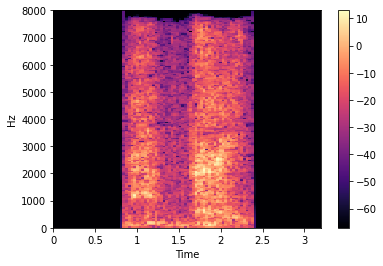

In [ ]:
s = get_spec('/content/drive/MyDrive/Dataset/Main/00/0583a369332c_01.wav', 16000)
print(s.shape)
librosa.display.specshow(s, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

Предъобработка обучающей выборки

In [ ]:
Y, Xs = get_data('/content/drive/MyDrive/Dataset/NewMain2/', 600, 13, 16000)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(Xs, Y, test_size=0.25, shuffle=True)

x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
print(x_train.shape)
print(y_train.shape)

torch.Size([4197, 160, 100])
torch.Size([4197])


In [ ]:
x_train = x_train.unsqueeze(1).float()
x_test = x_test.unsqueeze(1).float()
print(x_train.shape)
print(x_test.shape)
print(torch.cuda.is_available())

torch.Size([4197, 1, 160, 100])
torch.Size([1399, 1, 160, 100])
True


In [ ]:
class MySTTnet(torch.nn.Module):
    def __init__(self):
        super(MySTTnet, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,5), padding=(1,0)) # (160, 100)
        self.act1  = torch.nn.ReLU() 
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) # (160, 96)
        self.drop1 = torch.nn.Dropout2d(p=0.2)
       
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,1), padding=(2,0)) # (80, 48)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(4,2), stride=(4,2)) # (80, 48)
        self.drop2 = torch.nn.Dropout2d(p=0.2)

        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(7,1), padding=0) # (20, 24)
        self.act3  = torch.nn.ReLU()
        self.drop3 = torch.nn.Dropout2d(p=0.2)

        self.conv4 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,5), padding=0) # (14, 24)
        self.act4  = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=(14,20), stride=(14,20)) # (14, 20) --> (1, 1)
        
        self.fc1   = torch.nn.Linear(512, 128) # (512,) 
        self.act6  = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(128, 13) # (128,) 
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.drop3(x)

        x = self.conv4(x)
        x = self.act4(x)
        x = self.pool3(x) 
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act6(x)

        x = self.fc2(x)
        
        return x
    
sttnet = MySTTnet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sttnet = sttnet.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sttnet.parameters(), lr=0.5e-5)

In [ ]:
batch_size = 100

test_accuracy_history = []
train_accuracy_history = []
test_loss_history = []
train_loss_history = []
min_loss = 1000
max_acc = 0

for epoch in range(2000):
    print('Epoch', epoch + 1)

    cnt = 0
    sum_batch_loss = 0
    sum_batch_acc = 0
    order = np.random.permutation(len(x_train))
    for start_index in range(0, len(x_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = x_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = sttnet.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

        sum_batch_loss += loss(preds, y_batch).data.cpu()
        sum_batch_acc += (preds.argmax(dim=1) == y_batch).float().mean().data.cpu()
        cnt += 1
    
    train_loss = sum_batch_loss / cnt
    train_acc = sum_batch_acc / cnt
        
    cnt = 0
    sum_batch_loss = 0
    sum_batch_acc = 0
    for start_index in range(0, len(x_test), batch_size):
        cnt += 1

        X_batch = x_test[start_index:min(start_index+batch_size, len(x_test))].to(device)
        y_batch = y_test[start_index:min(start_index+batch_size, len(x_test))].to(device)
        test_preds = sttnet.forward(X_batch)

        sum_batch_loss += loss(test_preds, y_batch).data.cpu()
        sum_batch_acc += (test_preds.argmax(dim=1) == y_batch).float().mean().data.cpu()

    cur_loss = sum_batch_loss / cnt
    with open('/content/drive/MyDrive/Dataset/NewMain2/loss_history.txt', 'a') as file:
        file.write(str(float(cur_loss)) + ' ' + str(float(train_loss)) + '\n')
    test_loss_history.append(cur_loss)

    accuracy = sum_batch_acc / cnt
    with open('/content/drive/MyDrive/Dataset/NewMain2/accuracy_history.txt', 'a') as file:
        file.write(str(float(accuracy)) + ' ' + str(float(train_acc)) + '\n')
    test_accuracy_history.append(accuracy)

    if accuracy >= 0.9:
        save_name = '/content/drive/MyDrive/Dataset/newWeights3/acc=' + str(float(accuracy)) + '_loss=' + str(float(cur_loss)) + '_ep=' + str(epoch) + '.pth'
        if accuracy > max_acc:
            torch.save(mynet2.state_dict(), save_name)
            max_acc = accuracy
        elif cur_loss < min_loss:
            torch.save(mynet2.state_dict(), save_name)
            min_loss = cur_loss

    print('Accuracy = ' + str(accuracy) + '\tLoss = ' + str(cur_loss))

Epoch 1
Accuracy = tensor(0.0922)	Loss = tensor(2.5843)
Epoch 2
Accuracy = tensor(0.1229)	Loss = tensor(2.5533)
Epoch 3
Accuracy = tensor(0.1301)	Loss = tensor(2.5595)
Epoch 4
Accuracy = tensor(0.1358)	Loss = tensor(2.5641)
Epoch 5
Accuracy = tensor(0.1422)	Loss = tensor(2.5484)
Epoch 6
Accuracy = tensor(0.1422)	Loss = tensor(2.5460)
Epoch 7
Accuracy = tensor(0.1415)	Loss = tensor(2.5520)
Epoch 8
Accuracy = tensor(0.1358)	Loss = tensor(2.5497)
Epoch 9
Accuracy = tensor(0.1279)	Loss = tensor(2.5470)
Epoch 10
Accuracy = tensor(0.1394)	Loss = tensor(2.5474)
Epoch 11
Accuracy = tensor(0.1451)	Loss = tensor(2.5405)
Epoch 12
Accuracy = tensor(0.1437)	Loss = tensor(2.5392)
Epoch 13
Accuracy = tensor(0.1451)	Loss = tensor(2.5339)
Epoch 14
Accuracy = tensor(0.1401)	Loss = tensor(2.5279)
Epoch 15
Accuracy = tensor(0.1436)	Loss = tensor(2.5298)
Epoch 16
Accuracy = tensor(0.1429)	Loss = tensor(2.5314)
Epoch 17
Accuracy = tensor(0.1465)	Loss = tensor(2.5342)
Epoch 18
Accuracy = tensor(0.1451)	Loss 